In [77]:
import sys
import os
sys.path.append(os.path.abspath('../'))

import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from boruta import BorutaPy

from sklearn.cluster import DBSCAN
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    silhouette_score
)
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler

from scipy.spatial.distance import cdist

shap.initjs()

In [78]:
from src import Root
root = Root()
root.lib.jupyter_settings()

In [79]:
df = pd.read_csv("../data/housing_labeled.csv")

In [80]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,total_rooms_per_households,total_bedrooms_per_households,income_per_household,total_rooms_not_bedrooms,population_per_hosehold,income_per_population,total_rooms_not_bedrooms_per_households,distance_to_los_angeles,distance_to_san_francisco,distance_to_san_diego,distance_to_sacramento,distance_to_silicon_valley,distance_to_fresno,distance_to_santa_barbara,distance_to_san_jose,distance_to_oakland,distance_to_anaheim,distance_to_golden_gate_bridge,distance_to_yosemite_valley,distance_to_death_valley,distance_to_big_sur,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,is_high_value,target
0,-122.23,37.88,41.00,880.00,129.00,322.00,126.00,8.33,6.98,1.02,0.07,751.00,2.56,0.03,5.96,345.81,12.63,457.02,62.80,35.31,155.72,277.60,41.90,5.68,369.30,14.17,146.81,305.98,113.62,False,False,True,False,0.56,452600.00
1,-122.22,37.86,21.00,7099.00,1106.00,2401.00,1138.00,8.30,6.24,0.97,0.01,5993.00,2.11,0.00,5.27,344.42,12.37,455.61,63.54,33.84,154.56,276.13,40.42,4.75,367.91,14.36,146.28,305.08,112.15,False,False,True,False,0.25,358500.00
2,-122.24,37.85,52.00,1467.00,190.00,496.00,177.00,7.26,8.29,1.07,0.04,1277.00,2.80,0.01,7.21,344.62,11.08,455.79,64.76,33.48,155.18,276.11,40.32,3.58,368.13,13.17,147.38,305.94,111.71,False,False,True,False,0.44,352100.00
3,-122.25,37.85,52.00,1274.00,235.00,558.00,219.00,5.64,5.82,1.07,0.03,1039.00,2.55,0.01,4.74,344.98,10.60,456.15,65.10,33.65,155.66,276.40,40.58,3.35,368.50,12.63,147.93,306.46,111.83,False,False,True,False,0.07,341300.00
4,-122.25,37.85,52.00,1627.00,280.00,565.00,259.00,3.85,6.28,1.08,0.01,1347.00,2.18,0.01,5.20,344.98,10.60,456.15,65.10,33.65,155.66,276.40,40.58,3.35,368.50,12.63,147.93,306.46,111.83,False,False,True,False,0.06,342200.00


In [81]:
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'total_rooms_per_households', 'total_bedrooms_per_households',
       'income_per_household', 'total_rooms_not_bedrooms',
       'population_per_hosehold', 'income_per_population',
       'total_rooms_not_bedrooms_per_households', 'distance_to_los_angeles',
       'distance_to_san_francisco', 'distance_to_san_diego',
       'distance_to_sacramento', 'distance_to_silicon_valley',
       'distance_to_fresno', 'distance_to_santa_barbara',
       'distance_to_san_jose', 'distance_to_oakland', 'distance_to_anaheim',
       'distance_to_golden_gate_bridge', 'distance_to_yosemite_valley',
       'distance_to_death_valley', 'distance_to_big_sur',
       'ocean_proximity_INLAND', 'ocean_proximity_ISLAND',
       'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN',
       'is_high_value', 'target'],
      dtype='object')

In [82]:
def create_geospatial_features(df, eps=0.5, min_samples=5, plot=True):
    """
    Create geospatial features from latitude and longitude
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing 'latitude' and 'longitude' columns
    eps : float
        The maximum distance between two samples for them to be considered neighbors
    min_samples : int
        The minimum number of samples in a neighborhood for a point to be considered a core point
    plot : bool
        Whether to plot the clusters
        
    Returns:
    --------
    df_features : pandas DataFrame
        DataFrame with original data plus new geospatial features
    """
    # Make a copy of the input DataFrame to avoid modifying the original
    df_features = df.copy()
    
    # Extract coordinates for clustering
    coords = df_features[['latitude', 'longitude']].values
    
    # Standardize coordinates for DBSCAN
    coords_scaled = StandardScaler().fit_transform(coords)
    
    # Apply DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(coords_scaled)
    
    # Add cluster assignments to the features DataFrame
    df_features['cluster_id'] = clusters
    
    # Calculate cluster centroids (excluding noise points marked as -1)
    centroids = {}
    for cluster_id in set(clusters):
        if cluster_id != -1:  # Skip noise points
            mask = clusters == cluster_id
            centroids[cluster_id] = np.mean(coords[mask], axis=0)
    
    # Calculate distances to all centroids
    for cluster_id, centroid in centroids.items():
        df_features[f'dist_to_cluster_{cluster_id}'] = np.sqrt(
            (df_features['latitude'] - centroid[0])**2 + 
            (df_features['longitude'] - centroid[1])**2
        )
    
    # Calculate distance to nearest cluster centroid
    if centroids:
        centroid_array = np.array(list(centroids.values()))
        distances = cdist(coords, centroid_array)
        df_features['dist_to_nearest_centroid'] = np.min(distances, axis=1)
    
    # Convert cluster_id to a categorical feature
    df_features['cluster_id'] = df_features['cluster_id'].astype('category')
    
    # Plot the clusters if requested
    if plot and len(set(clusters)) > 1:
        plt.figure(figsize=(10, 8))
        
        # Plot points colored by cluster
        scatter = plt.scatter(
            df_features['longitude'], 
            df_features['latitude'], 
            c=df_features['cluster_id'], 
            cmap='viridis', 
            alpha=0.6, 
            s=50
        )
        
        # Plot centroids
        for cluster_id, centroid in centroids.items():
            plt.scatter(
                centroid[1], 
                centroid[0], 
                c='red', 
                marker='X', 
                s=200, 
                edgecolors='black'
            )
            plt.annotate(f'C{cluster_id}', (centroid[1], centroid[0]), fontsize=12)
        
        plt.colorbar(scatter, label='Cluster')
        plt.title('DBSCAN Clustering of Properties')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.grid(True, alpha=0.3)
        plt.show()
    
    return df_features

def optimize_dbscan_parameters(df, eps_range=(0.1, 2.0), min_samples_range=(3, 20), n_steps=10):
    """
    Find optimal DBSCAN parameters using silhouette score
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing 'latitude' and 'longitude' columns
    eps_range : tuple
        Range of eps values to try
    min_samples_range : tuple
        Range of min_samples values to try
    n_steps : int
        Number of values to try within each range
        
    Returns:
    --------
    best_eps : float
        Best eps value
    best_min_samples : int
        Best min_samples value
    """
    # Extract coordinates for clustering
    coords = df[['latitude', 'longitude']].values
    
    # Standardize coordinates for DBSCAN
    coords_scaled = StandardScaler().fit_transform(coords)
    
    best_score = -1
    best_eps = None
    best_min_samples = None
    
    # Generate parameter combinations to try
    eps_values = np.linspace(eps_range[0], eps_range[1], n_steps)
    min_samples_values = range(min_samples_range[0], min_samples_range[1] + 1)
    
    for eps in eps_values:
        for min_samples in min_samples_values:
            # Apply DBSCAN
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            clusters = dbscan.fit_predict(coords_scaled)
            
            # Skip if all points are noise or all in one cluster
            if len(set(clusters)) <= 2:
                continue
                
            # Calculate silhouette score (ignore noise points)
            if -1 in clusters and len(set(clusters)) > 2:
                # Filter out noise points for silhouette calculation
                mask = clusters != -1
                if np.sum(mask) > 1 and len(set(clusters[mask])) > 1:
                    score = silhouette_score(coords_scaled[mask], clusters[mask])
                else:
                    continue
            elif len(set(clusters)) > 1:
                score = silhouette_score(coords_scaled, clusters)
            else:
                continue
                
            if score > best_score:
                best_score = score
                best_eps = eps
                best_min_samples = min_samples
                
    print(f"Best parameters - eps: {best_eps}, min_samples: {best_min_samples}, silhouette score: {best_score:.4f}")
    return best_eps, best_min_samples

In [83]:
best_eps, best_min_samples = optimize_dbscan_parameters(df)
#eps: 0.1  min_samples:20

Best parameters - eps: 0.3111111111111111, min_samples: 3, silhouette score: 0.1583


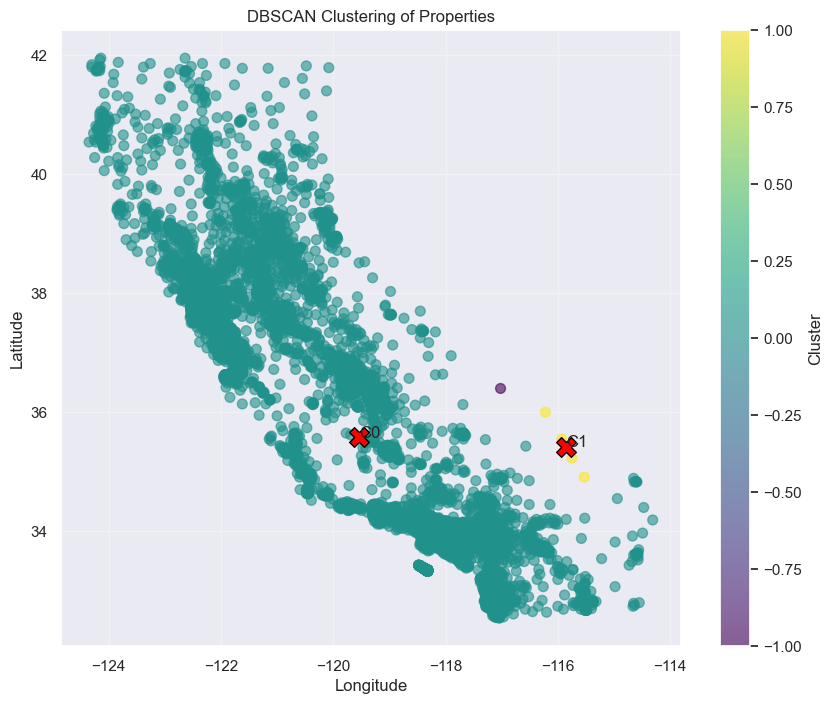

In [84]:
df_with_features = create_geospatial_features(df, eps=best_eps, min_samples=best_min_samples)

In [85]:
df_with_features["lat_sin"] = np.sin(np.radians(df_with_features["latitude"]))
df_with_features["lat_cos"] = np.cos(np.radians(df_with_features["latitude"]))
df_with_features["lon_sin"] = np.sin(np.radians(df_with_features["longitude"]))
df_with_features["lon_cos"] = np.cos(np.radians(df_with_features["longitude"]))
df_with_features = pd.get_dummies(df_with_features, columns=['cluster_id'], drop_first=True)


In [86]:
df_with_features.dtypes

longitude                                  float64
latitude                                   float64
housing_median_age                         float64
total_rooms                                float64
total_bedrooms                             float64
population                                 float64
households                                 float64
median_income                              float64
total_rooms_per_households                 float64
total_bedrooms_per_households              float64
income_per_household                       float64
total_rooms_not_bedrooms                   float64
population_per_hosehold                    float64
income_per_population                      float64
total_rooms_not_bedrooms_per_households    float64
distance_to_los_angeles                    float64
distance_to_san_francisco                  float64
distance_to_san_diego                      float64
distance_to_sacramento                     float64
distance_to_silicon_valley     

In [87]:

X = df_with_features.drop(columns = "target")
y = df_with_features["target"]

In [88]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize XGBoost regressor
xgb = XGBRegressor(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Initialize Boruta feature selector
boruta_selector = BorutaPy(
    estimator=xgb,
    n_estimators='auto',
    max_iter=50,  # Number of iterations
    verbose=2,    # Print progress
    random_state=42
)


boruta_selector.fit(np.array(X_train), np.array(y_train))
selected_features = X_train.columns[boruta_selector.support_].tolist()

Iteration: 	1 / 50
Confirmed: 	0
Tentative: 	43
Rejected: 	0
Iteration: 	2 / 50
Confirmed: 	0
Tentative: 	43
Rejected: 	0
Iteration: 	3 / 50
Confirmed: 	0
Tentative: 	43
Rejected: 	0
Iteration: 	4 / 50
Confirmed: 	0
Tentative: 	43
Rejected: 	0
Iteration: 	5 / 50
Confirmed: 	0
Tentative: 	43
Rejected: 	0
Iteration: 	6 / 50
Confirmed: 	0
Tentative: 	43
Rejected: 	0
Iteration: 	7 / 50
Confirmed: 	0
Tentative: 	43
Rejected: 	0
Iteration: 	8 / 50
Confirmed: 	16
Tentative: 	27
Rejected: 	0
Iteration: 	9 / 50
Confirmed: 	16
Tentative: 	25
Rejected: 	2
Iteration: 	10 / 50
Confirmed: 	16
Tentative: 	25
Rejected: 	2
Iteration: 	11 / 50
Confirmed: 	16
Tentative: 	25
Rejected: 	2
Iteration: 	12 / 50
Confirmed: 	22
Tentative: 	19
Rejected: 	2
Iteration: 	13 / 50
Confirmed: 	22
Tentative: 	19
Rejected: 	2
Iteration: 	14 / 50
Confirmed: 	22
Tentative: 	19
Rejected: 	2
Iteration: 	15 / 50
Confirmed: 	22
Tentative: 	19
Rejected: 	2
Iteration: 	16 / 50
Confirmed: 	29
Tentative: 	12
Rejected: 	2
Iteratio

In [89]:
selected_features

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'population',
 'households',
 'median_income',
 'total_rooms_per_households',
 'total_rooms_not_bedrooms',
 'population_per_hosehold',
 'total_rooms_not_bedrooms_per_households',
 'distance_to_los_angeles',
 'distance_to_san_francisco',
 'distance_to_san_diego',
 'distance_to_sacramento',
 'distance_to_silicon_valley',
 'distance_to_fresno',
 'distance_to_santa_barbara',
 'distance_to_san_jose',
 'distance_to_oakland',
 'distance_to_anaheim',
 'distance_to_golden_gate_bridge',
 'distance_to_yosemite_valley',
 'distance_to_death_valley',
 'distance_to_big_sur',
 'ocean_proximity_INLAND',
 'ocean_proximity_ISLAND',
 'ocean_proximity_NEAR BAY',
 'is_high_value',
 'dist_to_cluster_0',
 'dist_to_cluster_1',
 'dist_to_nearest_centroid',
 'lat_sin',
 'lat_cos',
 'lon_sin',
 'lon_cos']

In [90]:
def mean_absolute_percentage_error(y_true, y_pred):
    # Avoid division by zero
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

In [91]:
X = X[selected_features]
target = df_with_features["target"]
n_features = len(selected_features)

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=42)
X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values

n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

metrics = {
    'fold': [],
    'rmse': [],
    'mae': [],
    'mape': [],
    'r2': []
}

params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.1,
    'max_depth': 5,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'n_estimators': 100,
    'random_state': 42,
    'eval_metric': 'rmse'
}

# Store feature importances across folds
feature_importances = np.zeros(n_features)

In [93]:
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train), 1):

    X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
    y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]
    
    model = XGBRegressor(**params)
    model.fit(X_fold_train, y_fold_train)
    
    y_pred = model.predict(X_fold_val)
    
    rmse = np.sqrt(mean_squared_error(y_fold_val, y_pred))
    mae = mean_absolute_error(y_fold_val, y_pred)
    mape = mean_absolute_percentage_error(y_fold_val, y_pred)
    r2 = r2_score(y_fold_val, y_pred)
    
    metrics['fold'].append(fold)
    metrics['rmse'].append(rmse)
    metrics['mae'].append(mae)
    metrics['mape'].append(mape)
    metrics['r2'].append(r2)
    
    feature_importances += model.feature_importances_

In [94]:
feature_importances /= n_folds

final_model = XGBRegressor(**params)
final_model.fit(X_train, y_train)

y_test_pred = final_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"\nTest set - RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, MAPE: {test_mape:.4f}%, R²: {test_r2:.4f}")


Test set - RMSE: 43677.1980, MAE: 28829.1142, MAPE: 16.3465%, R²: 0.8634


In [95]:
metrics_df = pd.DataFrame(metrics)
mean_metrics = {
    'fold': 'Mean',
    'rmse': metrics_df['rmse'].mean(),
    'mae': metrics_df['mae'].mean(),
    'mape': metrics_df['mape'].mean(),
    'r2': metrics_df['r2'].mean()
}
metrics_df = pd.concat([metrics_df, pd.DataFrame([mean_metrics])], ignore_index=True)

metrics_df

,fold,rmse,mae,mape,r2
0,1,45845.68,29732.31,16.48,0.85
1,2,44069.95,29420.51,16.11,0.85
2,3,45004.24,30120.38,16.87,0.86
3,4,44142.90,29626.00,16.75,0.86
4,5,45386.69,29839.24,17.28,0.85
5,Mean,44889.89,29747.69,16.70,0.85



Feature Importances:
                                    Feature  Importance
28                            is_high_value        0.27
25                   ocean_proximity_INLAND        0.24
26                   ocean_proximity_ISLAND        0.19
6                             median_income        0.03
31                 dist_to_nearest_centroid        0.02
8                  total_rooms_not_bedrooms        0.01
19                      distance_to_oakland        0.01
30                        dist_to_cluster_1        0.01
18                     distance_to_san_jose        0.01
20                      distance_to_anaheim        0.01
11                  distance_to_los_angeles        0.01
29                        dist_to_cluster_0        0.01
33                                  lat_cos        0.01
34                                  lon_sin        0.01
16                       distance_to_fresno        0.01
27                 ocean_proximity_NEAR BAY        0.01
12                distance

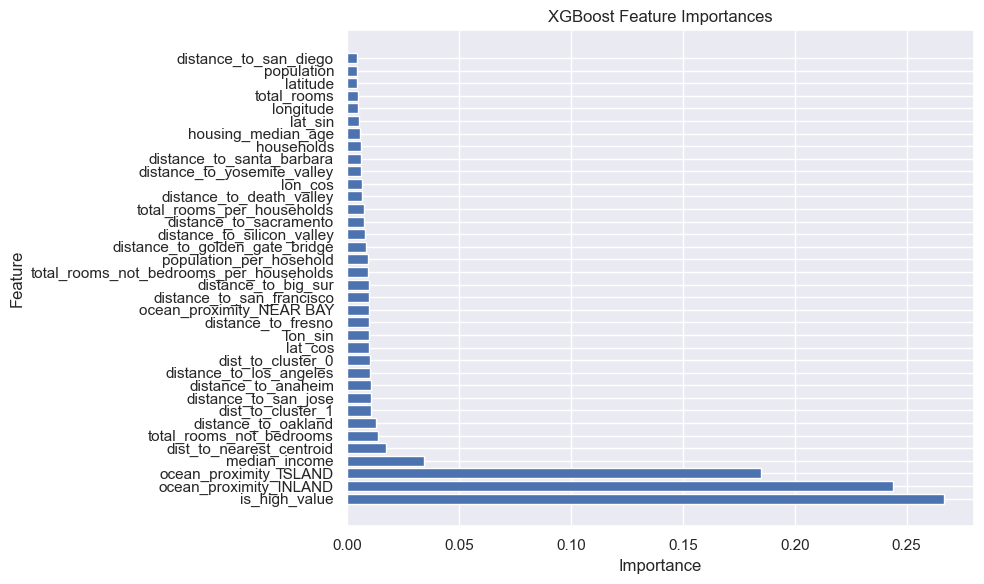

In [96]:
# Feature importances
importances_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(importances_df)

# Visualize feature importances
plt.figure(figsize=(10, 6))
plt.barh(importances_df['Feature'], importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('XGBoost Feature Importances')
plt.tight_layout()
plt.show()

In [97]:
final_model._xgb_dmatrix_props = {'enable_categorical': True}

explainer = shap.Explainer(final_model)
shap_values = explainer(X)

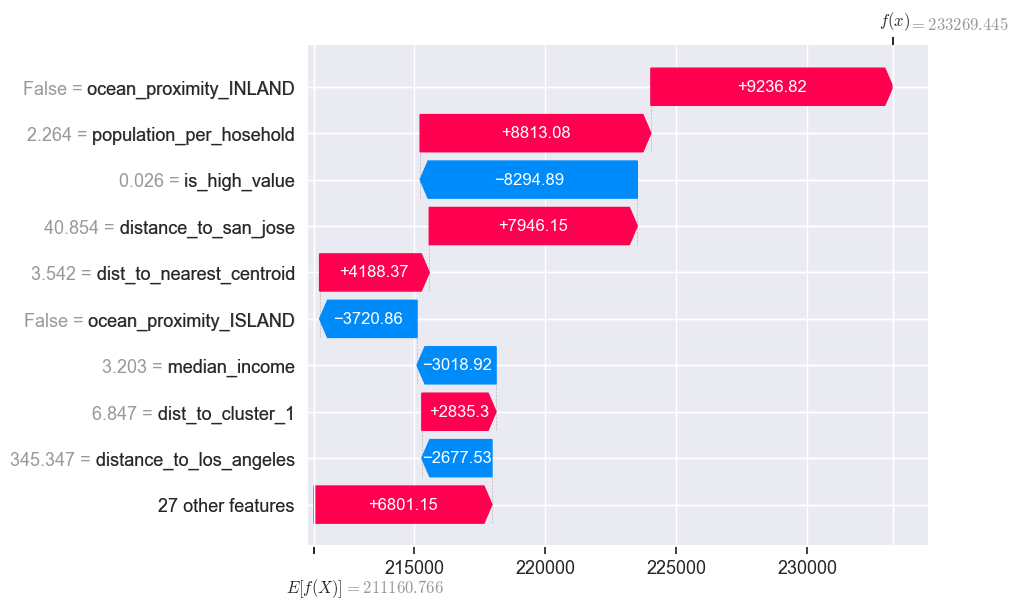

In [98]:
shap.plots.waterfall(shap_values[10])

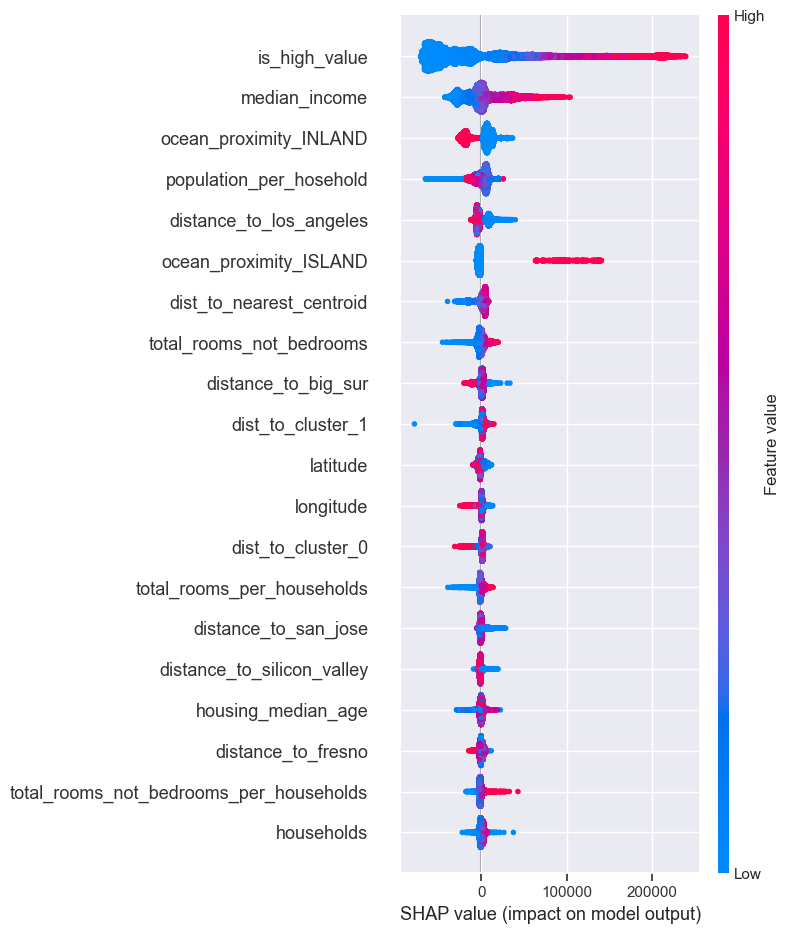

In [99]:
shap.summary_plot(shap_values, X)

In [100]:
shap.plots.force(shap_values[0])

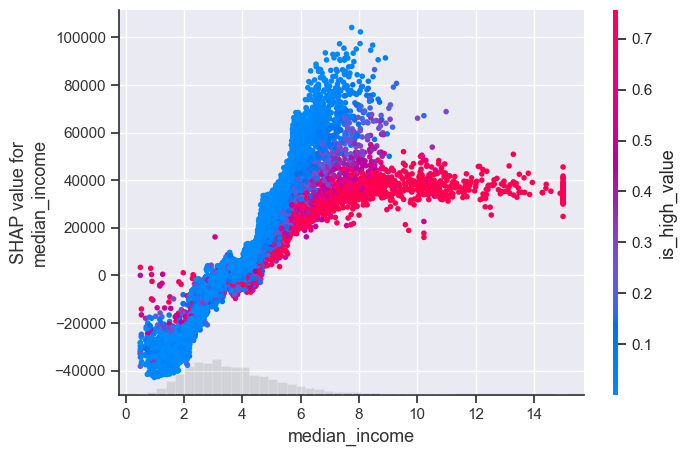

In [101]:
shap.plots.scatter(shap_values[:, "median_income"], color=shap_values)